In [10]:
#Importar las librerias

import numpy as np
import os
import shutil
import matplotlib.pyplot as plt 
import csv
import statistics as stats

from matplotlib.pyplot import hist, show
from matplotlib.colors import LinearSegmentedColormap
from scipy import ndimage
from skimage import morphology, data, exposure, img_as_float
from skimage import io, color, filters, util, measure
from skimage.measure import regionprops, label
from skimage.feature import peak_local_max
from skimage.filters import threshold_otsu, threshold_yen, threshold_sauvola, threshold_niblack
from skimage.color import rgb2hed, rgb2gray, label2rgb
from skimage.morphology import binary_erosion, binary_dilation, binary_opening, binary_closing
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, watershed, black_tophat
from skimage.morphology import disk, rectangle, diamond, square

raiz='hem/40X' #directorio raiz

In [11]:
#listar imagenes

def listar(de):
    #Variable para la ruta al directorio
    path = de
 
    #Lista vacia para incluir los ficheros
    name = []
 
    #Lista con todos los ficheros del directorio:
    lstDir = os.walk(path)   #os.walk() Lista directorios y ficheros
    #Crea una lista de los ficheros png que existen en el directorio y los incluye a la lista.
    i=0
    for root, dirs, files in lstDir: # recorre el direcctorio sacando los datos de las carpetas
        for fichero in files:
            (nombreFichero, extension) = os.path.splitext(fichero)
    
            if(extension == ".png"):
                name.append(nombreFichero)
                
        i += 1
        if i >= 1:
            break # rompe el ciclo para poder sacar solamente lo de la carpeta principal
    return name

def conver2(val, raiz):
    sol=0
    if(raiz=='hem/20X'):
        sol=(52.16*val)/551.02
    if(raiz=='hem/40X'):
        sol=(26.61*val)/551.02
    return sol

#Funcion para Imprimir
def plot_comparison(original, filtered):

    io.imshow(original)
    io.show()
    io.imshow(filtered)
    io.show()

In [ ]:
#linealizacion

path=raiz#directorio de trabajo

name = listar(raiz) # entra a la funcion para sacar los archivos .png

nuevaruta = r'hem/40x/linealizacion' #Ruta directorio
if not os.path.exists(nuevaruta): os.makedirs(nuevaruta) #Validar y crear directorio

for i in range(len(name)):
    img = io.imread(raiz+"/"+name[i]+'.png')  #leer Imagen 
    
    histo=exposure.histogram(img[:, :, 0]) #histograma de R

    a=histo[1].min() #valor minimo del histograma
    a1=histo[1].max() #valo maximo del histograma

    histo=exposure.histogram(img[:, :, 1]) #histograma de G

    b=histo[1].min() #valor minimo del histograma
    b1=histo[1].max() #valor maximo del histograma

    histo=exposure.histogram(img[:, :, 2]) #histograma de B

    c=histo[1].min() #valor minimo del histograma
    c1=histo[1].max() #valor maximo del histograma

    histo=exposure.histogram(img) #histograma de B

    d=histo[1].min() #valor minimo del histograma
    d1=histo[1].max() #valor maximo del histograma
    
    # parametros para las metricas de la linealizacion de histograma de acuerdo al tipo de imagen
    
    #img = exposure.equalize_adapthist(img)
    
    img = exposure.adjust_log(img,1)

    img[:, :, 0]= exposure.rescale_intensity(img[:, :, 0], in_range=(a, a1)) # 10X=1 / 20X=0.4 / 40x=0.7
    img[:, :, 1]= exposure.rescale_intensity(img[:, :, 1], in_range=(b, b1))   # 10X=2 / 20X=1   / 40x=1.2
    img[:, :, 2]= exposure.rescale_intensity(img[:, :, 2], in_range=(c, c1))   # 10X=4.5 / 20X=12   / 40x=4
    
    #img= exposure.rescale_intensity(img, in_range=(d, d1))   # 10X=4.5 / 20X=12   / 40x=4
    
    io.imshow(img) # imprimir imagen
    io.show()
    io.imsave(raiz+'/linealizacion/'+name[i]+'.png',(img)) #guardar la imagen con linealizado

In [ ]:
#Binarizacion

path = raiz+"/linealizacion" #directorio de trabajo local

name = listar(path) #listar los archivos .png en el directorio
nuevaruta = r'hem/40x/binario' 
if not os.path.exists(nuevaruta): os.makedirs(nuevaruta)
thd = [-1.173102169,-1.192465995,-1.225014023,-1.240406768,-1.293488523,-1.230943229,-1.248612401,-1.249052741,-1.268562234,-1.231118136,-1.216489031,-1.23691846,-1.249381578,-1.210164776,-1.268857464,-1.165200065,-1.180247586,-1.188015903,-1.199295101,-1.251871752,-1.205685504,-1.238225504,-1.259562186,-1.208562186,-1.262317355,-1.240176990,-1.219910830,-1.204511859,-1.279882681,-1.253751280,-1.293406089,-1.229896946,-1.225824506,-1.215725506,-1.239327103,-1.193876701,-1.228135827,-1.201320139,-1.205432413,-1.236000515,-1.238688543,-1.220218759,-1.229177911,-1.212173043,-1.215594925,-1.251959172,-1.236119490,-1.196797151,-1.208909601,-1.31823866,-1.30501570,-1.23438919,-1.26064966,-1.22307566,-1.22170225,-1.31823866,-1.30501570,-1.23438919,-1.26064966,-1.22307566,-1.22170225,-1.24740455,-1.22081700,-1.24582493,-1.24497881,-1.24872228]

for i in range(len(name)):
    
    ihc_rgb = io.imread(path+"/"+name[i]+'.png')
    ihc_hed = rgb2hed(ihc_rgb) #de RGB a HED (hematoxilina, eosina, dao)
    ihc_hed_np = np.array(ihc_hed) # de Numpy a uint8
    
    print(str(thd)+'\n')
    
    sol = ihc_hed_np[:,:,0] < thd[i]
    io.imshow(sol)
    io.show()
    
    sol = np.array(np.multiply(sol,255))
    
    io.imsave(raiz+'/binario/'+name[i]+'.png',(np.uint8(sol))) #guardar la imagen con binarizado

In [12]:
#Declaracion de vectores para graficas

#Nombres

n=[]

#Hibridos Totales
prof=[]
anoo=[]
mess=[]
area=[]
peri=[]
ecce=[]
eule=[]
diam=[]
majo=[]
mino=[]
iarea=[]
iperi=[]
iecce=[]
ieule=[]
idiam=[]
imajo=[]
imino=[]

#Puros Totales
prof1=[]
anoo1=[]
mess1=[]
area1=[]
peri1=[]
ecce1=[]
eule1=[]
diam1=[]
majo1=[]
mino1=[]
iarea1=[]
iperi1=[]
iecce1=[]
ieule1=[]
idiam1=[]
imajo1=[]
imino1=[]

#Matriz Hibridos
mprof=[]
manoo=[]
mmess=[]
marea=[]
mperi=[]
mecce=[]
meule=[]
mdiam=[]
mmajo=[]
mmino=[]
miarea=[]
miperi=[]
miecce=[]
mieule=[]
midiam=[]
mimajo=[]
mimino=[]

#Matriz Puros
mprof1=[]
manoo1=[]
mmess1=[]
marea1=[]
mperi1=[]
mecce1=[]
meule1=[]
mdiam1=[]
mmajo1=[]
mmino1=[]
miarea1=[]
miperi1=[]
miecce1=[]
mieule1=[]
midiam1=[]
mimajo1=[]
mimino1=[]

#Auxiliares

profaux=[]
anooaux=[]
messaux=[]
areaaux=[]
periaux=[]
ecceaux=[]
euleaux=[]
diamaux=[]
majoaux=[]
minoaux=[]
iareaaux=[]
iperiaux=[]
iecceaux=[]
ieuleaux=[]
idiamaux=[]
imajoaux=[]
iminoaux=[]

In [13]:
#Labeling

path = raiz+'/binarioM/' #directorio de imagenes binarias
name = listar(path) #listar los archivos .png en el directorio

try:
    import cPickle as pickle  
except ImportError:  
    import pickle 

f = open(raiz+'/40X Micras.txt','w')
s = open(raiz+'/40X Pixeles.txt','w')

f.write('nombre,identificador,tipo,profundidad,mes,año,area,perimeter,eccentricity,euler_number,equivalent_diameter,major_axis_length,minor_axis_length,min_row,min_col,max_row,max_col,area_in,perimeter_in,eccentricity_in,euler_number_in,equivalent_diameter_in,major_axis_length_in,minor_axis_length_in,min_row_in,min_col_in,max_row_in,max_col_in'+'\n')
s.write('nombre,identificador,tipo,profundidad,mes,año,area,perimeter,eccentricity,euler_number,equivalent_diameter,major_axis_length,minor_axis_length,min_row,min_col,max_row,max_col,area_in,perimeter_in,eccentricity_in,euler_number_in,equivalent_diameter_in,major_axis_length_in,minor_axis_length_in,min_row_in,min_col_in,max_row_in,max_col_in'+'\n')

for i in range(len(name)):
    
    blobs = io.imread(path+"/"+name[i]+'.png')  #leer Imagen
    
    all_labels = measure.label(blobs,8,255)
    blobs_labels = measure.label(blobs, background=0)
    
    io.imshow(blobs)
    io.show()

    io.imshow(all_labels)
    io.show()
    
    io.imshow(blobs_labels)
    io.show()
    
    prop=regionprops(all_labels) #lista de objetos cada objeto con n atributos de forma
    prop2=regionprops(blobs_labels)
    
    for j in range(len(prop)):
        if(name[i][0]=='a'):
            das='Cefalico'
        elif(name[i][0]=='b'):
            das='Medio'
        elif(name[i][0]=='c'):
            das='Caudal'
            
        if(name[i][2:4]=='16'):
            if(name[i][6]=='3'):
                sas='Puros Yaque'
                mes='mayo'
                ano='2017'
            elif(name[i][6]=='4'):
                sas='Puros Rayado'
                mes='mayo'
                ano='2017'
        elif(name[i][2:4]=='17'):
            sas='Hibridos'
            if(name[i][6]=='3'):
                mes='marzo'
                ano='2017'
            elif(name[i][6]=='4'):
                mes='mayo'
                ano='2017'

        if(name[i][0]=='h'):
            sas='Hibridos'
            
            if(name[i][7:9]=='25'):
                mes='enero'
                ano='2017'
            elif(name[i][7:9]=='28'):
                mes='septiembre'
                ano='2016'
            elif((name[i][7:9]=='93') or (name[i][7:9]=='94') or (name[i][7:9]=='27') or (name[i][5:9]=='1738')):
                mes='julio'
                ano='2016'
                
            if(name[i][19]=='1' or name[i][19]=='4' or name[i][19]=='7'):
                das='Cefalico'
            elif(name[i][19]=='2' or name[i][19]=='5' or name[i][19]=='8'):
                das='Medio'
            elif(name[i][19]=='3' or name[i][19]=='6' or name[i][19]=='9'):
                das='Caudal'  
            
            
        cont=0
        print(conver2(prop[j].equivalent_diameter,raiz))
        if (conver2(prop[j].equivalent_diameter,raiz) >= 16) or (conver2(prop[j].equivalent_diameter,raiz) <= 1200):
            mnr,mnc,mxr,mxc = prop[j].bbox
            for k in range(len(prop2)):
                mnr1,mnc1,mxr1,mxc1 = prop2[k].bbox
                if mnr<mnr1 and mnc<mnc1 and mxr>mxr1 and mxc>mxc1:
                    f.write(str(name[i]+'.png')+','+str(j)+','+sas+','+das+','+mes+','+ano+','+str(conver2(prop[j].area,raiz))+','+str(conver2(prop[j].perimeter,raiz))+','+str(conver2(prop[j].eccentricity,raiz))+','+str(conver2(prop[j].euler_number,raiz))+','+str(conver2(prop[j].equivalent_diameter,raiz))+','+str(conver2(prop[j].major_axis_length,raiz))+','+str(conver2(prop[j].minor_axis_length,raiz))+','+str(prop[j].bbox)+','+str(conver2(prop2[k].area,raiz))+','+str(conver2(prop2[k].perimeter,raiz))+','+str(conver2(prop2[k].eccentricity,raiz))+','+str(conver2(prop2[k].euler_number,raiz))+','+str(conver2(prop2[k].equivalent_diameter,raiz))+','+str(conver2(prop2[k].major_axis_length,raiz))+','+str(conver2(prop2[k].minor_axis_length,raiz))+','+str(prop2[k].bbox)+'\n')
                    s.write(str(name[i]+'.png')+','+str(j)+','+sas+','+das+','+mes+','+ano+','+str(prop[j].area)+','+str(prop[j].perimeter)+','+str(prop[j].eccentricity)+','+str(prop[j].euler_number)+','+str(prop[j].equivalent_diameter)+','+str(prop[j].major_axis_length)+','+str(prop[j].minor_axis_length)+','+str(prop[j].bbox)+','+str(prop2[k].area)+','+str(prop2[k].perimeter)+','+str(prop2[k].eccentricity)+','+str(prop2[k].euler_number)+','+str(prop2[k].equivalent_diameter)+','+str(prop2[k].major_axis_length)+','+str(prop2[k].minor_axis_length)+','+str(prop2[k].bbox)+'\n')
                    cont=1
                    if(sas=='Puros Yaque' or sas=='Puros Rayado'):
                        prof1.append(das)
                        anoo1.append(ano)
                        mess1.append(mes)
                        area1.append(conver2(prop[j].area,raiz))
                        peri1.append(conver2(prop[j].perimeter,raiz))
                        ecce1.append(conver2(prop[j].eccentricity,raiz))
                        eule1.append(conver2(prop[j].euler_number,raiz))
                        diam1.append(conver2(prop[j].equivalent_diameter,raiz))
                        majo1.append(conver2(prop[j].major_axis_length,raiz))
                        mino1.append(conver2(prop[j].minor_axis_length,raiz))
                        iarea1.append(conver2(prop2[k].area,raiz))
                        iperi1.append(conver2(prop2[k].perimeter,raiz))
                        iecce1.append(conver2(prop2[k].eccentricity,raiz))
                        ieule1.append(conver2(prop2[k].euler_number,raiz))
                        idiam1.append(conver2(prop2[k].equivalent_diameter,raiz))
                        imajo1.append(conver2(prop2[k].major_axis_length,raiz))
                        imino1.append(conver2(prop2[k].minor_axis_length,raiz))
                        
                    elif(sas=='Hibridos'):
                        prof.append(das)
                        anoo.append(ano)
                        mess.append(mes)
                        area.append(conver2(prop[j].area,raiz))
                        peri.append(conver2(prop[j].perimeter,raiz))
                        ecce.append(conver2(prop[j].eccentricity,raiz))
                        eule.append(conver2(prop[j].euler_number,raiz))
                        diam.append(conver2(prop[j].equivalent_diameter,raiz))
                        majo.append(conver2(prop[j].major_axis_length,raiz))
                        mino.append(conver2(prop[j].minor_axis_length,raiz))
                        iarea.append(conver2(prop2[k].area,raiz))
                        iperi.append(conver2(prop2[k].perimeter,raiz))
                        iecce.append(conver2(prop2[k].eccentricity,raiz))
                        ieule.append(conver2(prop2[k].euler_number,raiz))
                        idiam.append(conver2(prop2[k].equivalent_diameter,raiz))
                        imajo.append(conver2(prop2[k].major_axis_length,raiz))
                        imino.append(conver2(prop2[k].minor_axis_length,raiz))
                    break
                elif cont==len(prop2):
                    f.write(str(name[i]+'.png')+','+str(j)+','+sas+','+das+','+mes+','+ano+','+str(conver2(prop[j].area,raiz))+','+str(conver2(prop[j].perimeter,raiz))+','+str(prop[j].eccentricity)+','+str(prop[j].euler_number)+','+str(conver2(prop[j].equivalent_diameter,raiz))+','+str(conver2(prop[j].major_axis_length,raiz))+','+str(conver2(prop[j].minor_axis_length,raiz))+','+str(prop[j].bbox)+',0,0,0,0,0,0,0,0,0,0,0'+'\n')
                    s.write(str(name[i]+'.png')+','+str(j)+','+sas+','+das+','+mes+','+ano+','+str(prop[j].area)+','+str(prop[j].perimeter)+','+str(prop[j].eccentricity)+','+str(prop[j].euler_number)+','+str(prop[j].equivalent_diameter)+','+str(prop[j].major_axis_length)+','+str(prop[j].minor_axis_length)+','+str(prop[j].bbox)+',0,0,0,0,0,0,0,0,0,0,0'+'\n')
                    if(sas=='Puros Yaque' or sas=='Puros Rayado'):
                        prof1.append(das)
                        anoo1.append(ano)
                        mess1.append(mes)
                        area1.append(conver2(prop[j].area,raiz))
                        peri1.append(conver2(prop[j].perimeter,raiz))
                        ecce1.append(conver2(prop[j].eccentricity,raiz))
                        eule1.append(conver2(prop[j].euler_number,raiz))
                        diam1.append(conver2(prop[j].equivalent_diameter,raiz))
                        majo1.append(conver2(prop[j].major_axis_length,raiz))
                        mino1.append(conver2(prop[j].minor_axis_length,raiz))
                        iarea1.append(0)
                        iperi1.append(0)
                        iecce1.append(0)
                        ieule1.append(0)
                        idiam1.append(0)
                        imajo1.append(0)
                        imino1.append(0)
                    elif(sas=='Hibridos'):
                        prof.append(das)
                        anoo.append(ano)
                        mess.append(mes)
                        area.append(conver2(prop[j].area,raiz))
                        peri.append(conver2(prop[j].perimeter,raiz))
                        ecce.append(conver2(prop[j].eccentricity,raiz))
                        eule.append(conver2(prop[j].euler_number,raiz))
                        diam.append(conver2(prop[j].equivalent_diameter,raiz))
                        majo.append(conver2(prop[j].major_axis_length,raiz))
                        mino.append(conver2(prop[j].minor_axis_length,raiz))
                        iarea.append(0)
                        iperi.append(0)
                        iecce.append(0)
                        ieule.append(0)
                        idiam.append(0)
                        imajo.append(0)
                        imino.append(0)
                    break
f.close()
s.close()

In [5]:
#Separacion de datos en la matriz
#For para los Puros

lprof = ['Cefalico','Medio','Caudal']
lano = ['2016','2016','2017','2017','2017']
lmes = ['julio','septiembre','enero','marzo','mayo']

for b in range(len(lprof)):
    for c in range(len(lano)):
        for j in range(len(prof1)):
            if(prof1[j]==lprof[b] and anoo1[j]==lano[c] and mess1[j]==lmes[c]):
                profaux.append(prof1[j])
                anooaux.append(anoo1[j])
                messaux.append(mess1[j])
                areaaux.append(area1[j])
                periaux.append(peri1[j])
                ecceaux.append(ecce1[j])
                euleaux.append(eule1[j])
                diamaux.append(diam1[j])
                majoaux.append(majo1[j])
                minoaux.append(mino1[j])
                iareaaux.append(iarea1[j])
                iperiaux.append(iperi1[j])
                iecceaux.append(iecce1[j])
                ieuleaux.append(ieule1[j])
                idiamaux.append(idiam1[j])
                imajoaux.append(imajo1[j])
                iminoaux.append(imino1[j])
        mprof1.append(profaux)
        manoo1.append(anooaux)
        mmess1.append(messaux)
        marea1.append(areaaux)
        mperi1.append(periaux)
        mecce1.append(ecceaux)
        meule1.append(euleaux)
        mdiam1.append(diamaux)
        mmajo1.append(majoaux)
        mmino1.append(minoaux)
        miarea1.append(iareaaux)
        miperi1.append(iperiaux)
        miecce1.append(iecceaux)
        mieule1.append(ieuleaux)
        midiam1.append(idiamaux)
        mimajo1.append(imajoaux)
        mimino1.append(iminoaux)

        #Matrices en 0

        profaux=[]
        anooaux=[]
        messaux=[]
        areaaux=[]
        periaux=[]
        ecceaux=[]
        euleaux=[]
        diamaux=[]
        majoaux=[]
        minoaux=[]
        iareaaux=[]
        iperiaux=[]
        iecceaux=[]
        ieuleaux=[]
        idiamaux=[]
        imajoaux=[]
        iminoaux=[]
        
#For para los Hibridos

for b in range(len(lprof)):
    for c in range(len(lano)):
        for j in range(len(prof)):
            if(prof[j]==lprof[b] and anoo[j]==lano[c] and mess[j]==lmes[c]):
                profaux.append(prof[j])
                anooaux.append(anoo[j])
                messaux.append(mess[j])
                areaaux.append(area[j])
                periaux.append(peri[j])
                ecceaux.append(ecce[j])
                euleaux.append(eule[j])
                diamaux.append(diam[j])
                majoaux.append(majo[j])
                minoaux.append(mino[j])
                iareaaux.append(iarea[j])
                iperiaux.append(iperi[j])
                iecceaux.append(iecce[j])
                ieuleaux.append(ieule[j])
                idiamaux.append(idiam[j])
                imajoaux.append(imajo[j])
                iminoaux.append(imino[j])
        mprof.append(profaux)
        manoo.append(anooaux)
        mmess.append(messaux)
        marea.append(areaaux)
        mperi.append(periaux)
        mecce.append(ecceaux)
        meule.append(euleaux)
        mdiam.append(diamaux)
        mmajo.append(majoaux)
        mmino.append(minoaux)
        miarea.append(iareaaux)
        miperi.append(iperiaux)
        miecce.append(iecceaux)
        mieule.append(ieuleaux)
        midiam.append(idiamaux)
        mimajo.append(imajoaux)
        mimino.append(iminoaux)

        #Matrices en 0

        profaux=[]
        anooaux=[]
        messaux=[]
        areaaux=[]
        periaux=[]
        ecceaux=[]
        euleaux=[]
        diamaux=[]
        majoaux=[]
        minoaux=[]
        iareaaux=[]
        iperiaux=[]
        iecceaux=[]
        ieuleaux=[]
        idiamaux=[]
        imajoaux=[]
        iminoaux=[]

In [34]:
#estadisticos

puros=[marea1,mperi1,mecce1,meule1,mdiam1,mmajo1,mmino1,miarea1,miperi1,miecce1,mieule1,midiam1,mimajo1,mimino1]
hibri=[marea,mperi,mecce,meule,mdiam,mmajo,mmino,miarea,miperi,miecce,mieule,midiam,mimajo,mimino]
nomb=['Area','Perimetro','Excentricidad','Numero_de_Euler','Diametro','Longitud_Mayor','Longitud_Menor','Area_Interna','Perimetro_interno','Excentricidad_Interna','Numero_de_Euler_Interno','Diametro_Interno','Longitud_Mayor_Interna','Longitud_Menor_Interna']
prof=['Cefalico','Medio','Caudal']

#Análisis estadistico Puros
i=0
for a in range(len(prof)):
    for b in range(len(puros)):
        if puros[b][0+i]!=[]:
            print('Puro juli 2016 '+prof[a])
            print("Mediana "+nomb[b]+' '+str(stats.mean(puros[b][0+i])))
            print("Media "+nomb[b]+' '+str(stats.median(puros[b][0+i])))
            print("Moda "+nomb[b]+' '+str(stats.mode(puros[b][0+i])))
            print("Varianza Poblacional "+nomb[b]+' '+str(stats.pvariance(puros[b][0+i])))
            print("Desviacion Estandar "+nomb[b]+' '+str(stats.pstdev(puros[b][0+i])))
            print()

        if puros[b][1+i]!=[]:
            print('Puro sept 2016 '+prof[a])    
            print("Mediana "+nomb[b]+' '+str(stats.mean(puros[b][1+i])))
            print("Media "+nomb[b]+' '+str(stats.median(puros[b][1+i])))
            print("Moda "+nomb[b]+' '+str(stats.mode(puros[b][1+i])))
            print("Varianza Poblacional "+nomb[b]+' '+str(stats.pvariance(puros[b][1+i])))
            print("Desviacion Estandar "+nomb[b]+' '+str(stats.pstdev(puros[b][1+i])))
            print()

        if puros[b][2+i]!=[]:
            print('Puro ener 2017 '+prof[a])    
            print("Mediana "+nomb[b]+' '+str(stats.mean(puros[b][2+i])))
            print("Media "+nomb[b]+' '+str(stats.median(puros[b][2+i])))
            print("Moda "+nomb[b]+' '+str(stats.mode(puros[b][2+i])))
            print("Varianza Poblacional "+nomb[b]+' '+str(stats.pvariance(puros[b][2+i])))
            print("Desviacion Estandar "+nomb[b]+' '+str(stats.pstdev(puros[b][2+i])))
            print()

        if puros[b][3+i]!=[]:
            print('Puro marz 2017 '+prof[a])    
            print("Mediana "+nomb[b]+' '+str(stats.mean(puros[b][3+i])))
            print("Media "+nomb[b]+' '+str(stats.median(puros[b][3+i])))
            print("Moda "+nomb[b]+' '+str(stats.mode(puros[b][3+i])))
            print("Varianza Poblacional "+nomb[b]+' '+str(stats.pvariance(puros[b][3+i])))
            print("Desviacion Estandar "+nomb[b]+' '+str(stats.pstdev(puros[b][3+i])))
            print()

        if puros[b][4+i]!=[]:
            print('Puro mayo 2017 '+prof[a])    
            print("Mediana "+nomb[b]+' '+str(stats.mean(puros[b][4+i])))
            print("Media "+nomb[b]+' '+str(stats.median(puros[b][4+i])))
            #print("Moda "+nomb[b]+' '+str(stats.mode(puros[b][4+i])))
            print("Varianza Poblacional "+nomb[b]+' '+str(stats.pvariance(puros[b][4+i])))
            print("Desviacion Estandar "+nomb[b]+' '+str(stats.pstdev(puros[b][4+i])))
            print()
    
    i=i+5
    
#Análisis estadistico Hibridos
i=0
for a in range(len(prof)):
    for b in range(len(hibri)):
        if hibri[b][0+i]!=[]:
            print('Hibrido juli 2016 '+prof[a])
            print("Mediana "+nomb[b]+' '+str(stats.mean(hibri[b][0+i])))
            print("Media "+nomb[b]+' '+str(stats.median(hibri[b][0+i])))
            #print("Moda "+nomb[b]+' '+str(stats.mode(hibri[b][0+i])))
            print("Varianza Poblacional "+nomb[b]+' '+str(stats.pvariance(hibri[b][0+i])))
            print("Desviacion Estandar "+nomb[b]+' '+str(stats.pstdev(hibri[b][0+i])))
            print()

        if hibri[b][1+i]!=[]:
            print('Hibrido sept 2016 '+prof[a])    
            print("Mediana "+nomb[b]+' '+str(stats.mean(hibri[b][1+i])))
            print("Media "+nomb[b]+' '+str(stats.median(hibri[b][1+i])))
            #print("Moda "+nomb[b]+' '+str(stats.mode(hibri[b][1+i])))
            print("Varianza Poblacional "+nomb[b]+' '+str(stats.pvariance(hibri[b][1+i])))
            print("Desviacion Estandar "+nomb[b]+' '+str(stats.pstdev(hibri[b][1+i])))
            print()

        if hibri[b][2+i]!=[]:
            print('Hibrido ener 2017 '+prof[a])    
            print("Mediana "+nomb[b]+' '+str(stats.mean(hibri[b][2+i])))
            print("Media "+nomb[b]+' '+str(stats.median(hibri[b][2+i])))
            #print("Moda "+nomb[b]+' '+str(stats.mode(hibri[b][2+i])))
            print("Varianza Poblacional "+nomb[b]+' '+str(stats.pvariance(hibri[b][2+i])))
            print("Desviacion Estandar "+nomb[b]+' '+str(stats.pstdev(hibri[b][2+i])))
            print()

        if hibri[b][3+i]!=[]:
            print('Hibrido marz 2017 '+prof[a])    
            print("Mediana "+nomb[b]+' '+str(stats.mean(hibri[b][3+i])))
            print("Media "+nomb[b]+' '+str(stats.median(hibri[b][3+i])))
            #print("Moda "+nomb[b]+' '+str(stats.mode(hibri[b][3+i])))
            print("Varianza Poblacional "+nomb[b]+' '+str(stats.pvariance(hibri[b][3+i])))
            print("Desviacion Estandar "+nomb[b]+' '+str(stats.pstdev(hibri[b][3+i])))
            print()

        if hibri[b][4+i]!=[]:
            print('Hibrido mayo 2017 '+prof[a])    
            print("Mediana "+nomb[b]+' '+str(stats.mean(hibri[b][4+i])))
            print("Media "+nomb[b]+' '+str(stats.median(hibri[b][4+i])))
            #print("Moda "+nomb[b]+' '+str(stats.mode(hibri[b][4+i])))
            print("Varianza Poblacional "+nomb[b]+' '+str(stats.pvariance(hibri[b][4+i])))
            print("Desviacion Estandar "+nomb[b]+' '+str(stats.pstdev(hibri[b][4+i])))
            print()
    
    i=i+5

Puro mayo 2017 Cefalico
Mediana Area 5026.211158048151
Media Area 3263.4942107364527
Varianza Poblacional Area 21032909.62224639
Desviacion Estandar Area 4586.165023442396

Puro mayo 2017 Cefalico
Mediana Perimetro 147.54283163647833
Media Perimetro 113.08901179632362
Varianza Poblacional Perimetro 18719.770621763055
Desviacion Estandar Perimetro 136.82021276756976

Puro mayo 2017 Cefalico
Mediana Excentricidad 0.034752162320092005
Media Excentricidad 0.03525538550937609
Varianza Poblacional Excentricidad 5.2351025961524204e-05
Desviacion Estandar Excentricidad 0.007235400884645177

Puro mayo 2017 Cefalico
Mediana Numero_de_Euler -4.171708132889215
Media Numero_de_Euler -1.5936445138107511
Varianza Poblacional Numero_de_Euler 52.61511478082126
Desviacion Estandar Numero_de_Euler 7.253627697974391

Puro mayo 2017 Cefalico
Mediana Diametro 16.036175792116893
Media Diametro 14.165608624275231
Varianza Poblacional Diametro 51.89079040999285
Desviacion Estandar Diametro 7.203526248303177

P

Desviacion Estandar Numero_de_Euler 2.622135089910427

Hibrido marz 2017 Cefalico
Mediana Numero_de_Euler -11.608835695911747
Media Numero_de_Euler -3.6702116075641538
Varianza Poblacional Numero_de_Euler 496.7855817651224
Desviacion Estandar Numero_de_Euler 22.288687304664723

Hibrido mayo 2017 Cefalico
Mediana Numero_de_Euler -1.9034086659176122
Media Numero_de_Euler -0.9175529018910384
Varianza Poblacional Numero_de_Euler 10.790086448840992
Desviacion Estandar Numero_de_Euler 3.28482669997079

Hibrido juli 2016 Cefalico
Mediana Diametro 26.40832044566264
Media Diametro 5.243419604242125
Varianza Poblacional Diametro 926.0453809453027
Desviacion Estandar Diametro 30.43099375546751

Hibrido sept 2016 Cefalico
Mediana Diametro 8.681409320278853
Media Diametro 7.383512188763548
Varianza Poblacional Diametro 10.968719038203439
Desviacion Estandar Diametro 3.3119056505588196

Hibrido marz 2017 Cefalico
Mediana Diametro 12.80915091552797
Media Diametro 10.427451799463967
Varianza Poblacion

Varianza Poblacional Numero_de_Euler 103.56123690509583
Desviacion Estandar Numero_de_Euler 10.176504159341548

Hibrido mayo 2017 Medio
Mediana Numero_de_Euler -1.6719790485805184
Media Numero_de_Euler -0.7968222569053756
Varianza Poblacional Numero_de_Euler 9.695859916840316
Desviacion Estandar Numero_de_Euler 3.113817579249034

Hibrido juli 2016 Medio
Mediana Diametro 27.844167761959334
Media Diametro 28.916711139498176
Varianza Poblacional Diametro 242.51818267369512
Desviacion Estandar Diametro 15.572995301922335

Hibrido marz 2017 Medio
Mediana Diametro 10.758022967915362
Media Diametro 11.355975782416404
Varianza Poblacional Diametro 33.44725430800951
Desviacion Estandar Diametro 5.783360122628498

Hibrido mayo 2017 Medio
Mediana Diametro 10.603062484514567
Media Diametro 10.089250904181863
Varianza Poblacional Diametro 13.474521864874395
Desviacion Estandar Diametro 3.6707658417385325

Hibrido juli 2016 Medio
Mediana Longitud_Mayor 62.41022578637343
Media Longitud_Mayor 55.61071

Desviacion Estandar Longitud_Mayor 5.918309094850473

Hibrido juli 2016 Caudal
Mediana Longitud_Menor 19.36939261030856
Media Longitud_Menor 11.167451583168907
Varianza Poblacional Longitud_Menor 530.5445411094461
Desviacion Estandar Longitud_Menor 23.033552507362952

Hibrido ener 2017 Caudal
Mediana Longitud_Menor 15.297511818161935
Media Longitud_Menor 16.20339758948509
Varianza Poblacional Longitud_Menor 56.034109801608416
Desviacion Estandar Longitud_Menor 7.485593483592895

Hibrido marz 2017 Caudal
Mediana Longitud_Menor 9.729616168503235
Media Longitud_Menor 7.823996210560529
Varianza Poblacional Longitud_Menor 25.364660299230522
Desviacion Estandar Longitud_Menor 5.036334013866686

Hibrido mayo 2017 Caudal
Mediana Longitud_Menor 10.219285250666323
Media Longitud_Menor 9.29914961770071
Varianza Poblacional Longitud_Menor 17.35912086775578
Desviacion Estandar Longitud_Menor 4.166427830618908

Hibrido juli 2016 Caudal
Mediana Area_Interna 3942.019752459076
Media Area_Interna 1.6902

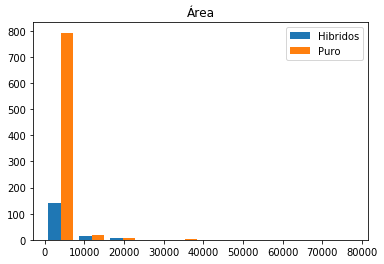

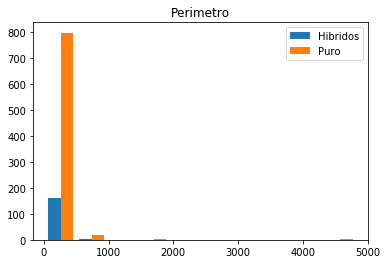

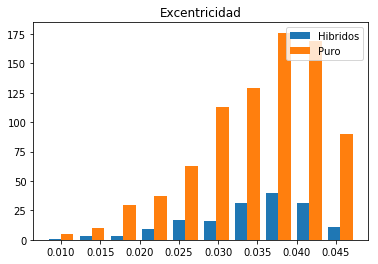

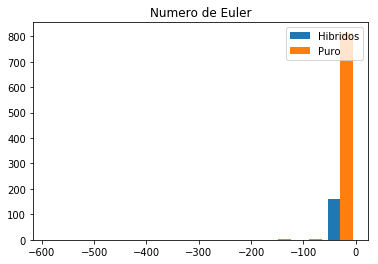

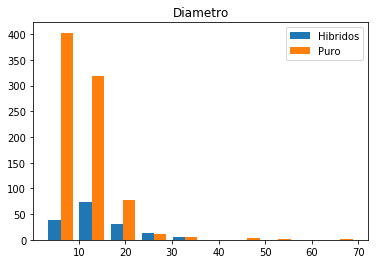

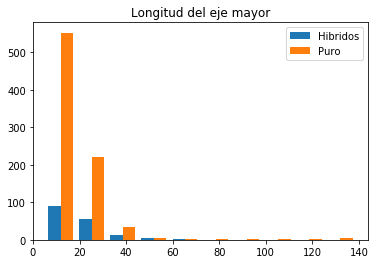

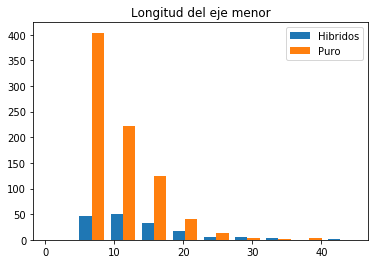

In [12]:
#histogramas Externos

plt.hist([area1,area], label=['Hibridos','Puro'])
plt.legend(loc='upper right')
plt.title("Área")
plt.savefig(raiz+" area.png",bbox_inches='tight')
plt.show()

plt.hist([peri1,peri], label=['Hibridos','Puro'])
plt.legend(loc='upper right')
plt.title("Perimetro")
plt.savefig(raiz+" perimetro.png",bbox_inches='tight')
plt.show()

plt.hist([ecce1,ecce], label=['Hibridos','Puro'])
plt.legend(loc='upper right')
plt.title("Excentricidad")
plt.savefig(raiz+" excentricidad.png",bbox_inches='tight')
plt.show()

plt.hist([eule1,eule], label=['Hibridos','Puro'])
plt.legend(loc='upper right')
plt.title("Numero de Euler")
plt.savefig(raiz+" numero_euler.png",bbox_inches='tight')
plt.show()

plt.hist([diam1,diam], label=['Hibridos','Puro'])
plt.legend(loc='upper right')
plt.title("Diametro")
plt.savefig(raiz+" Diametro.png",bbox_inches='tight')
plt.show()

plt.hist([majo1,majo], label=['Hibridos','Puro'])
plt.legend(loc='upper right')
plt.title("Longitud del eje mayor")
plt.savefig(raiz+" Longitud_mayor.png",bbox_inches='tight')
plt.show()

plt.hist([mino1,mino], range=[0, 45], label=['Hibridos','Puro'])
plt.legend(loc='upper right')
plt.title("Longitud del eje menor")
plt.savefig(raiz+" Longitud_menor.png",bbox_inches='tight')
plt.show()

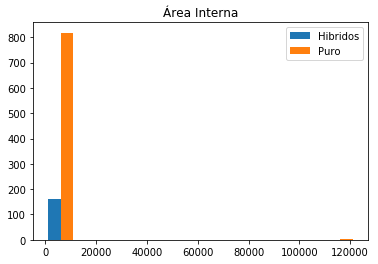

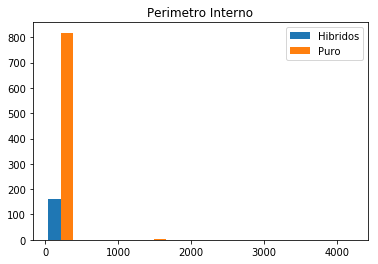

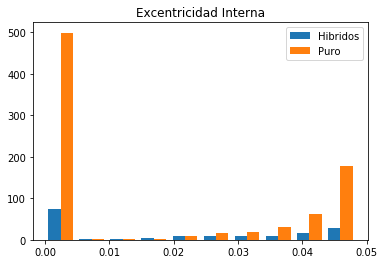

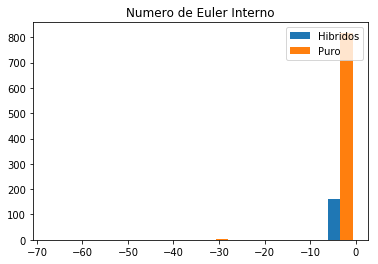

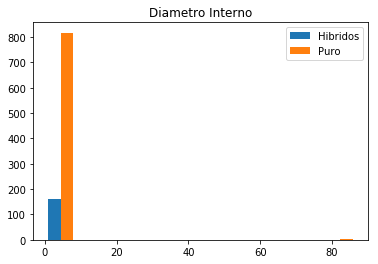

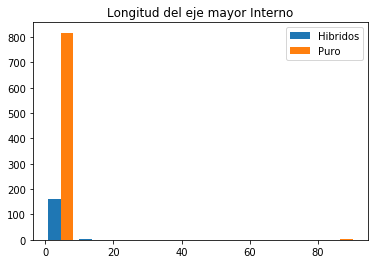

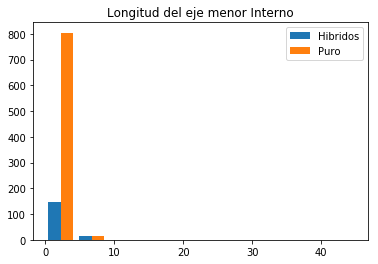

In [13]:
#histogramas Internos

plt.hist([iarea1,iarea], label=['Hibridos','Puro'])
plt.legend(loc='upper right')
plt.title("Área Interna")
plt.savefig(raiz+" area_interna.png",bbox_inches='tight')
plt.show()

plt.hist([iperi1,iperi], label=['Hibridos','Puro'])
plt.legend(loc='upper right')
plt.title("Perimetro Interno")
plt.savefig(raiz+" perimetro_interno.png",bbox_inches='tight')
plt.show()

plt.hist([iecce1,iecce], label=['Hibridos','Puro'])
plt.legend(loc='upper right')
plt.title("Excentricidad Interna")
plt.savefig(raiz+" excentricidad_interna.png",bbox_inches='tight')
plt.show()

plt.hist([ieule1,ieule], label=['Hibridos','Puro'])
plt.legend(loc='upper right')
plt.title("Numero de Euler Interno")
plt.savefig(raiz+" numero_euler_interno.png",bbox_inches='tight')
plt.show()

plt.hist([idiam1,idiam], label=['Hibridos','Puro'])
plt.legend(loc='upper right')
plt.title("Diametro Interno")
plt.savefig(raiz+" Diametro_interno.png",bbox_inches='tight')
plt.show()

plt.hist([imajo1,imajo], label=['Hibridos','Puro'])
plt.legend(loc='upper right')
plt.title("Longitud del eje mayor Interno")
plt.savefig(raiz+" Longitud_mayor_interna.png",bbox_inches='tight')
plt.show()

plt.hist([imino1,imino], range=[0, 45], label=['Hibridos','Puro'])
plt.legend(loc='upper right')
plt.title("Longitud del eje menor Interno")
plt.savefig(raiz+" Longitud_menor_interna.png",bbox_inches='tight')
plt.show()

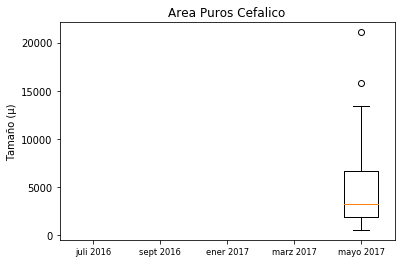

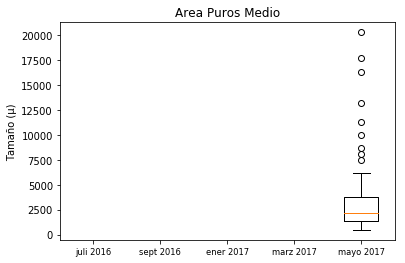

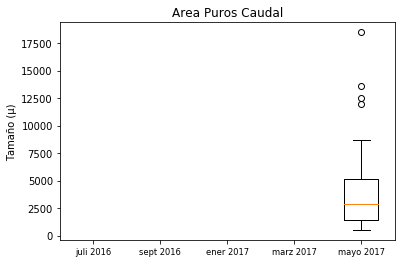

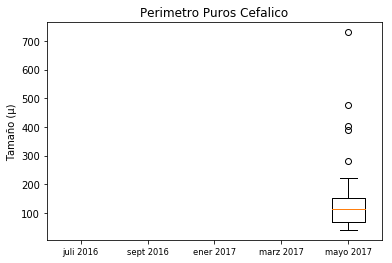

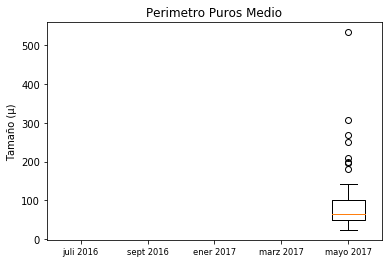

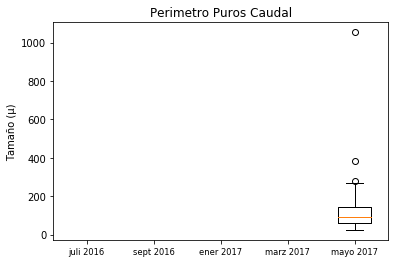

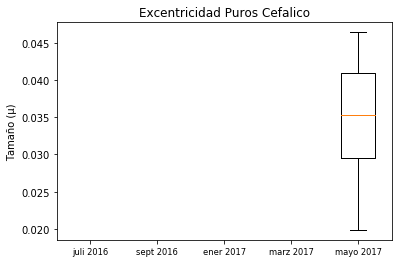

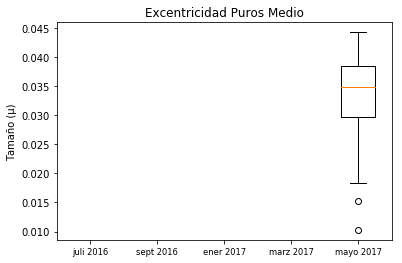

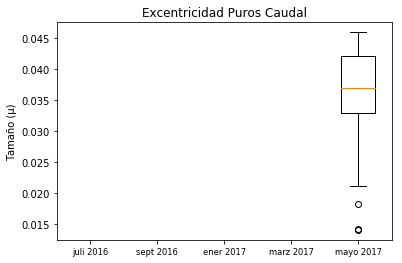

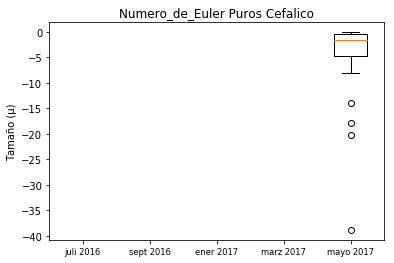

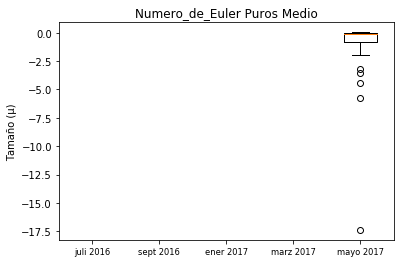

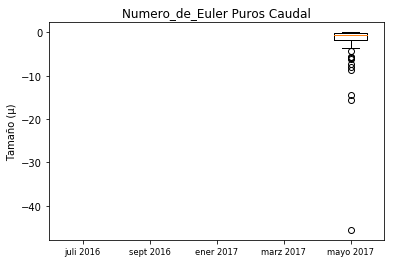

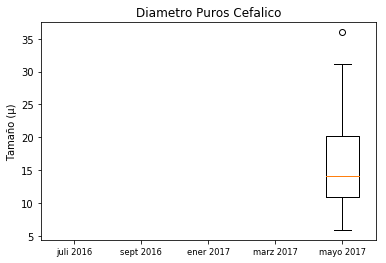

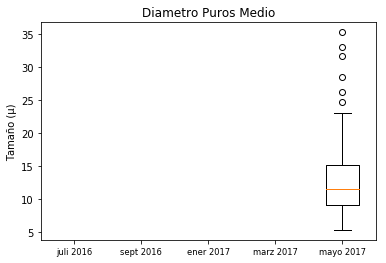

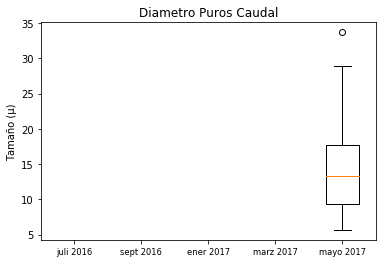

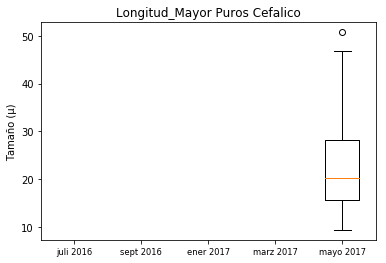

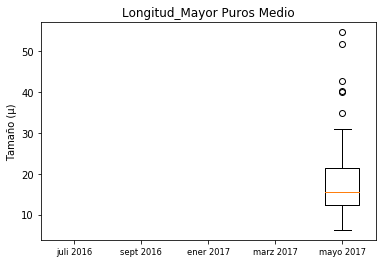

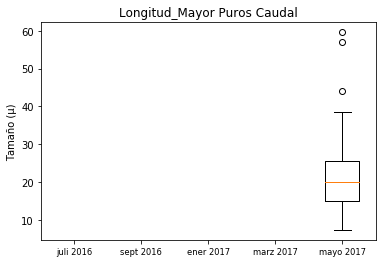

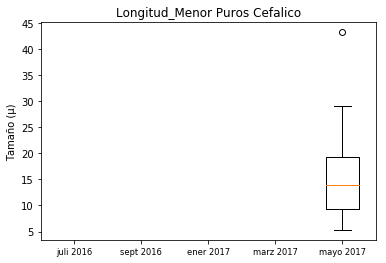

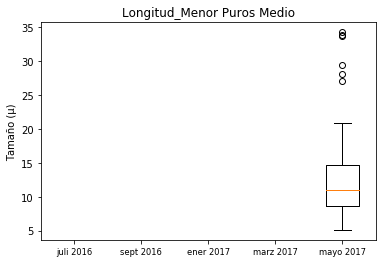

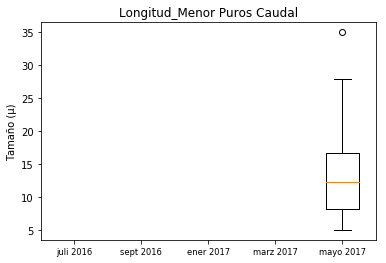

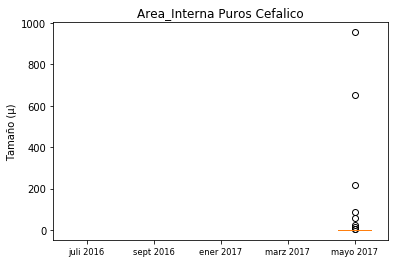

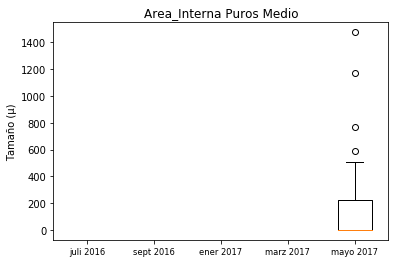

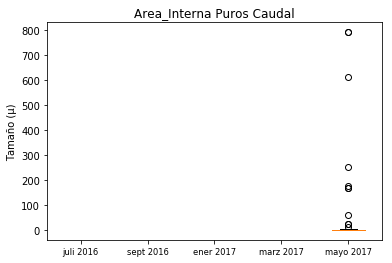

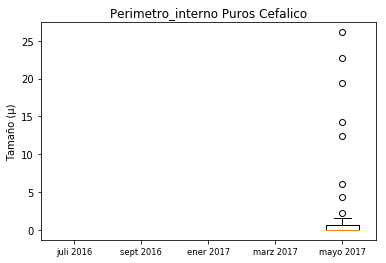

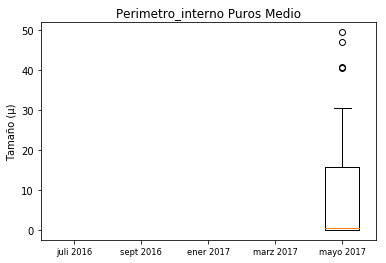

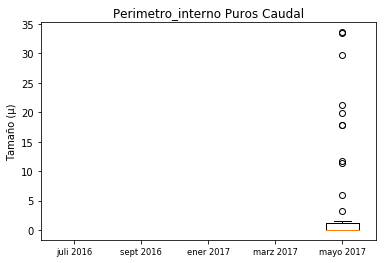

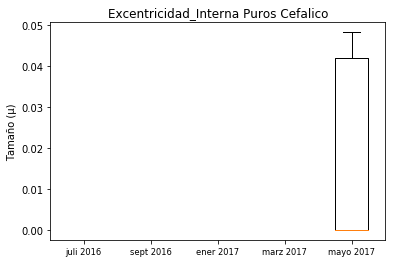

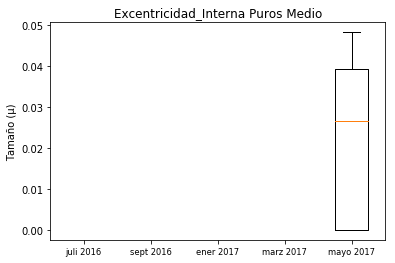

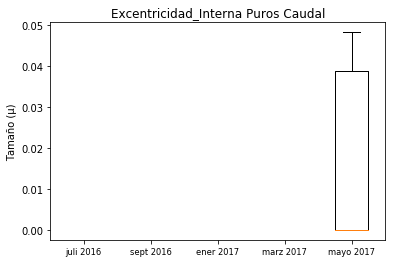

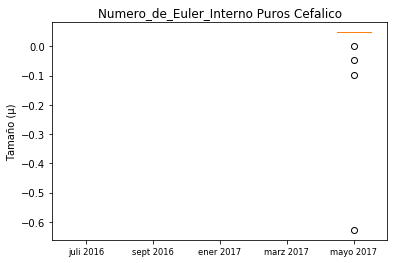

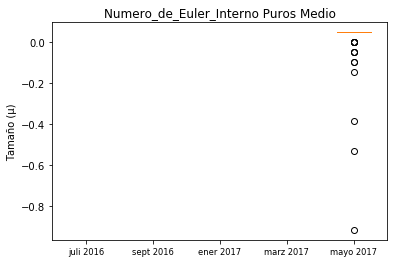

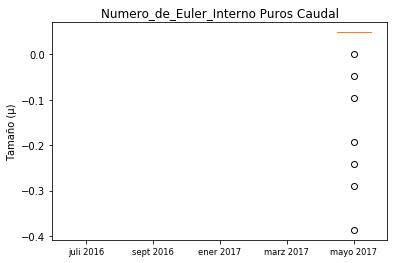

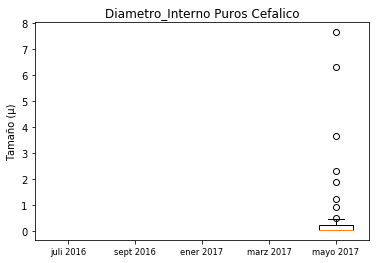

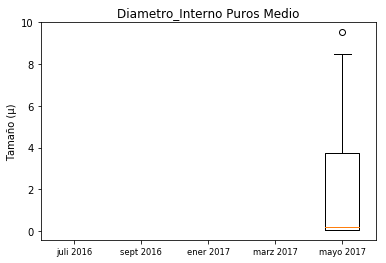

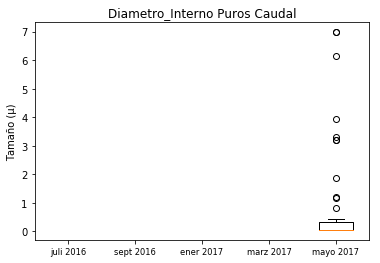

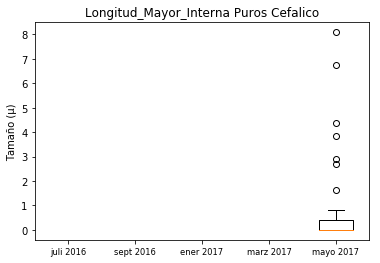

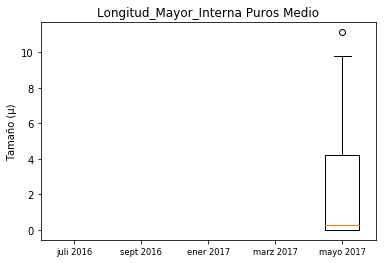

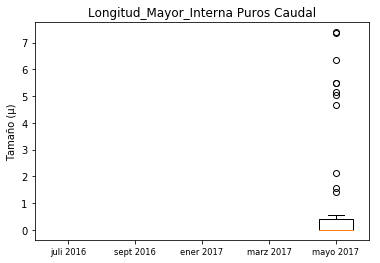

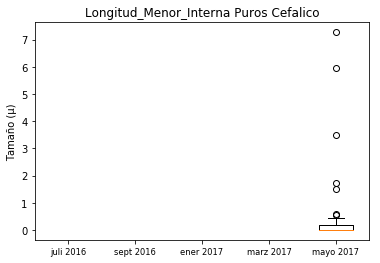

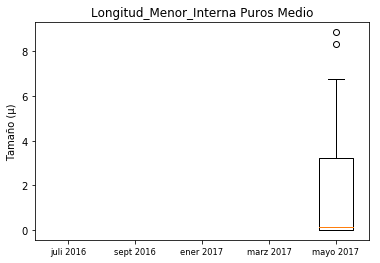

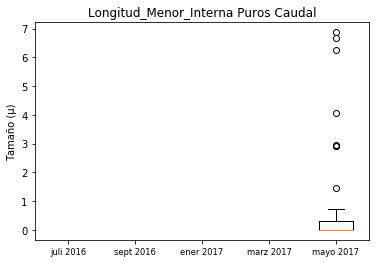

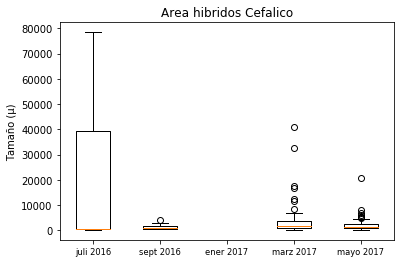

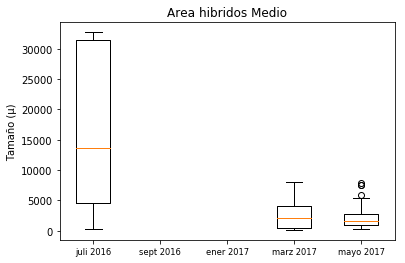

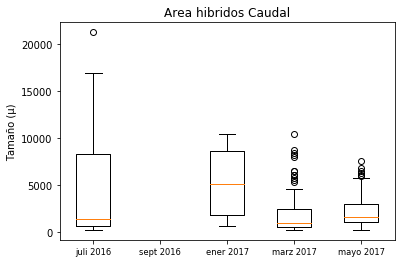

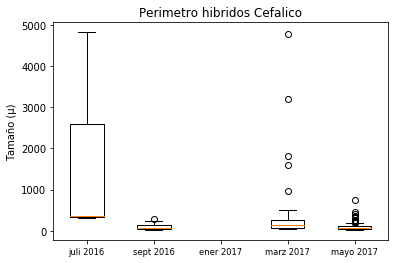

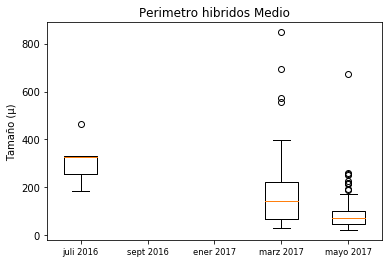

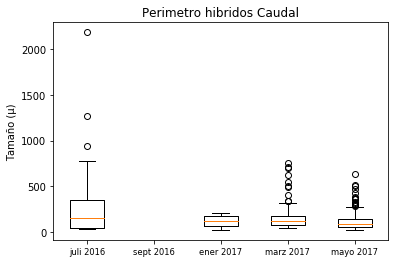

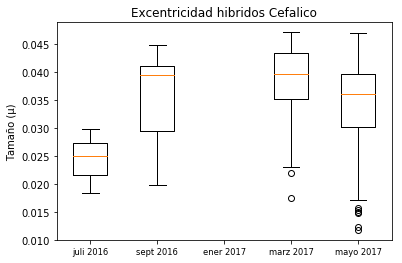

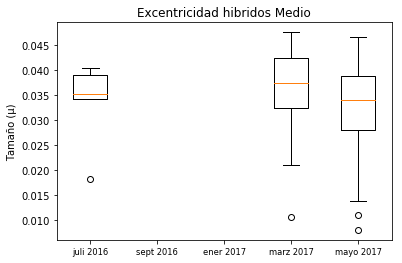

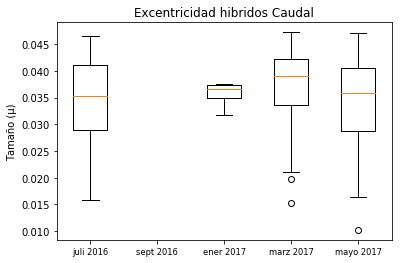

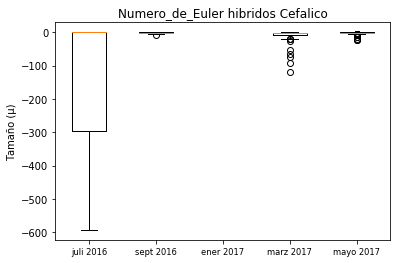

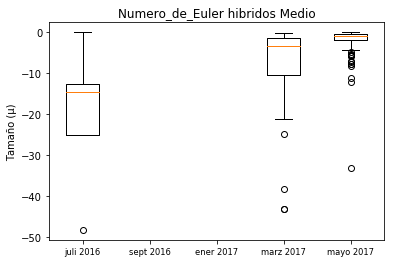

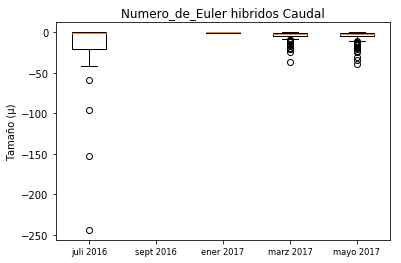

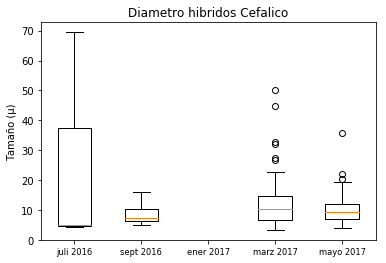

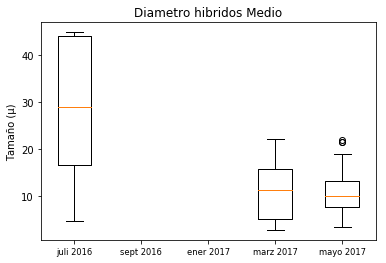

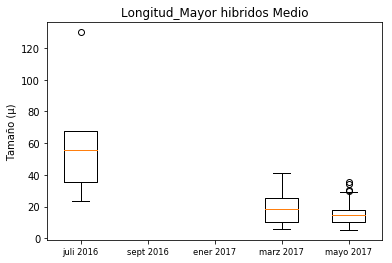

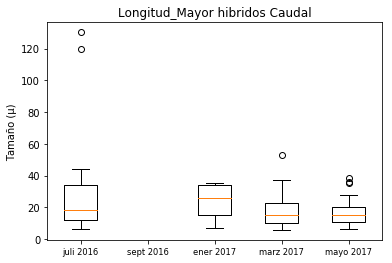

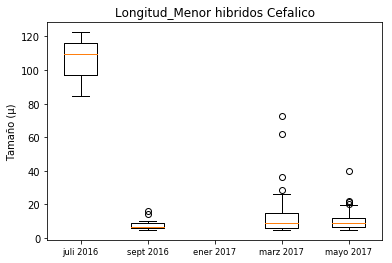

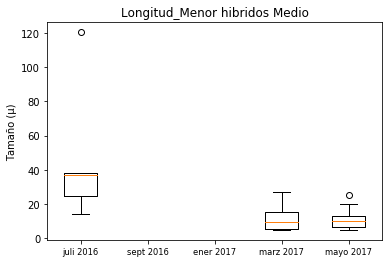

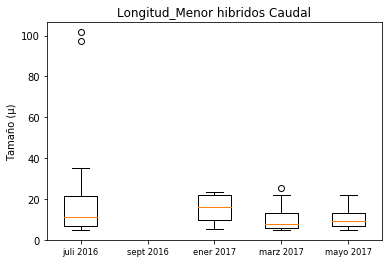

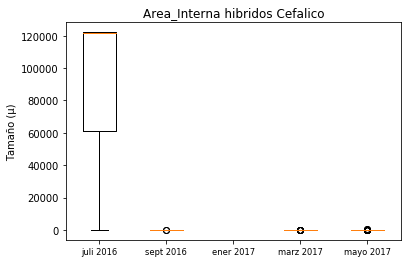

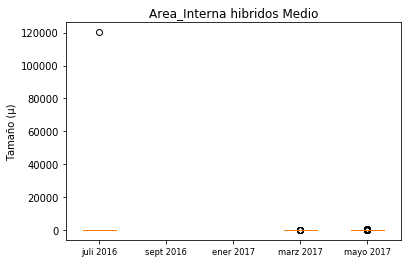

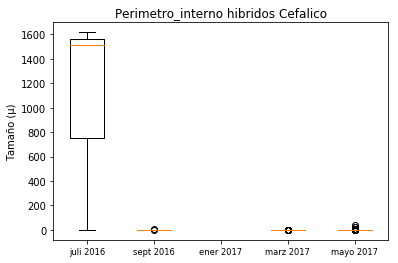

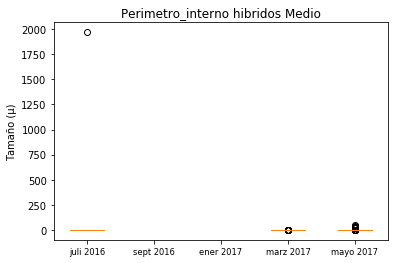

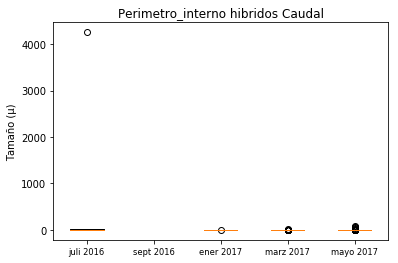

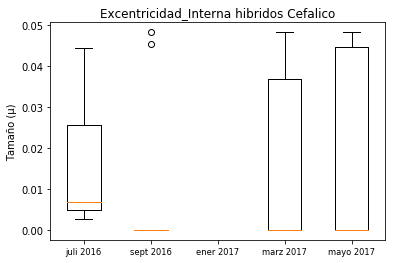

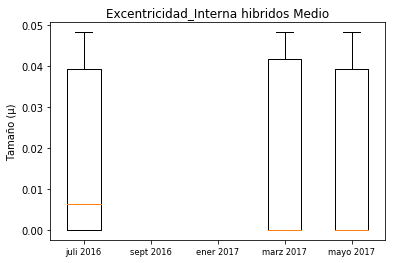

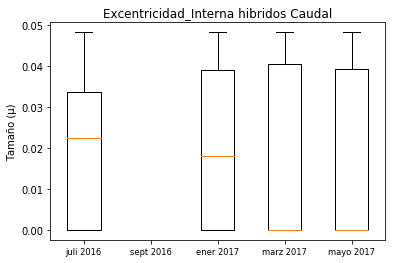

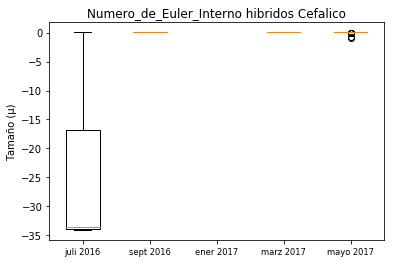

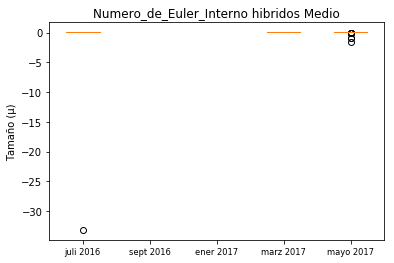

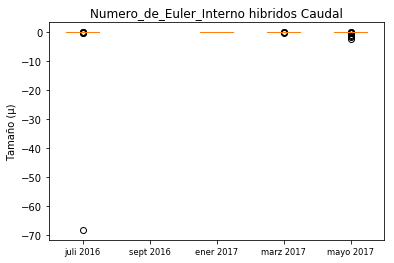

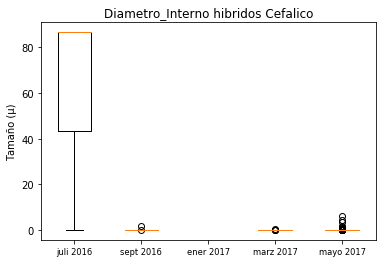

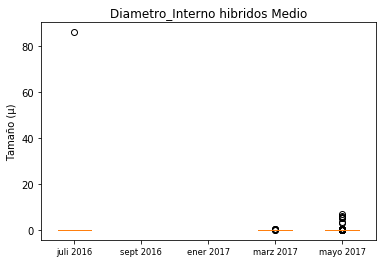

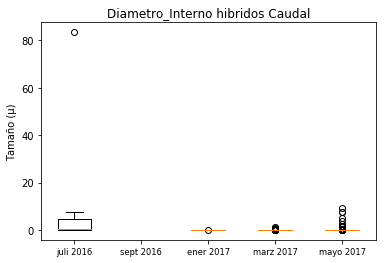

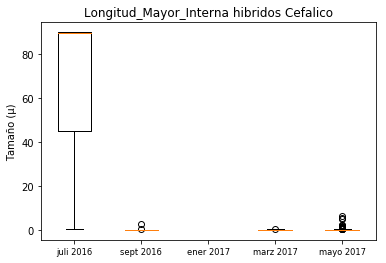

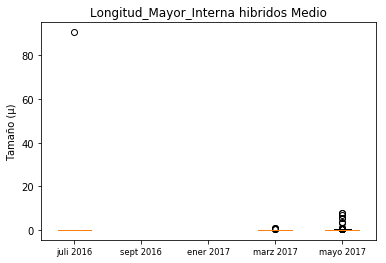

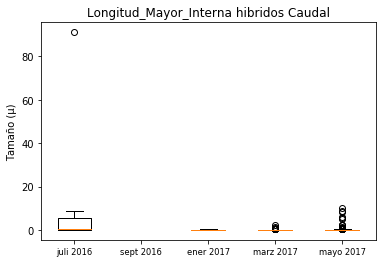

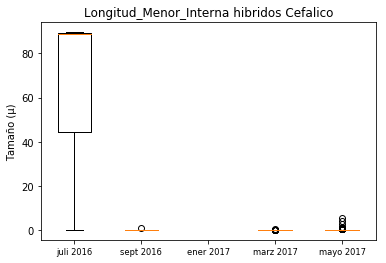

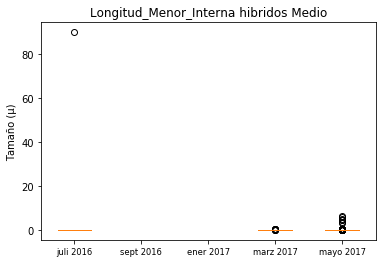

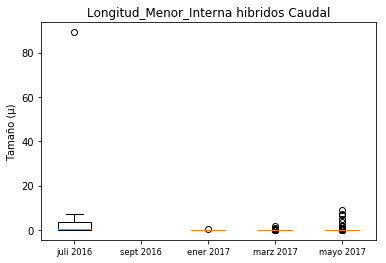

In [35]:
#Cajas Fechas

puros=[marea1,mperi1,mecce1,meule1,mdiam1,mmajo1,mmino1,miarea1,miperi1,miecce1,mieule1,midiam1,mimajo1,mimino1]
hibri=[marea,mperi,mecce,meule,mdiam,mmajo,mmino,miarea,miperi,miecce,mieule,midiam,mimajo,mimino]
nomb=['Area','Perimetro','Excentricidad','Numero_de_Euler','Diametro','Longitud_Mayor','Longitud_Menor','Area_Interna','Perimetro_interno','Excentricidad_Interna','Numero_de_Euler_Interno','Diametro_Interno','Longitud_Mayor_Interna','Longitud_Menor_Interna']

#Caracteristicas

for b in range(len(puros)):

    plt.ion()
    plt.boxplot([puros[b][0],puros[b][1],puros[b][2],puros[b][3],puros[b][4]])
    plt.xticks([1,2,3,4,5], ['juli 2016', 'sept 2016','ener 2017', 'marz 2017', 'mayo 2017'], size = 'small', color = 'k')  # Colocamos las etiquetas para cada distribución
    plt.ylabel(u'Tamaño (µ)')
    plt.title(nomb[b] +' Puros Cefalico')
    plt.savefig(raiz+nomb[b]+"PCEFALICO.png",bbox_inches='tight')
    plt.show()

    plt.ion()
    plt.boxplot([puros[b][5],puros[b][6],puros[b][7],puros[b][8],puros[b][9]])
    plt.xticks([1,2,3,4,5], ['juli 2016', 'sept 2016','ener 2017', 'marz 2017', 'mayo 2017'], size = 'small', color = 'k')  # Colocamos las etiquetas para cada distribución
    plt.ylabel(u'Tamaño (µ)')
    plt.title(nomb[b] +' Puros Medio')
    plt.savefig(raiz+nomb[b]+"PMEDIO.png",bbox_inches='tight')
    plt.show()

    plt.ion()
    plt.boxplot([puros[b][10],puros[b][11],puros[b][12],puros[b][13],puros[b][14]])
    plt.xticks([1,2,3,4,5], ['juli 2016', 'sept 2016','ener 2017', 'marz 2017', 'mayo 2017'], size = 'small', color = 'k')  # Colocamos las etiquetas para cada distribución
    plt.ylabel(u'Tamaño (µ)')
    plt.title(nomb[b] +' Puros Caudal')
    plt.savefig(raiz+nomb[b]+"PCAUDAL.png",bbox_inches='tight')
    plt.show()

for b in range(len(hibri)):
    
    plt.ion()
    plt.boxplot([hibri[b][0],hibri[b][1],hibri[b][2],hibri[b][3],hibri[b][4]])
    plt.xticks([1,2,3,4,5], ['juli 2016', 'sept 2016','ener 2017', 'marz 2017', 'mayo 2017'], size = 'small', color = 'k')  # Colocamos las etiquetas para cada distribución
    plt.ylabel(u'Tamaño (µ)')
    plt.title(nomb[b] +' hibridos Cefalico')
    plt.savefig(raiz+nomb[b]+"HCEFALICO.png",bbox_inches='tight')
    plt.show()

    plt.ion()
    plt.boxplot([hibri[b][5],hibri[b][6],hibri[b][7],hibri[b][8],hibri[b][9]])
    plt.xticks([1,2,3,4,5], ['juli 2016', 'sept 2016','ener 2017', 'marz 2017', 'mayo 2017'], size = 'small', color = 'k')  # Colocamos las etiquetas para cada distribución
    plt.ylabel(u'Tamaño (µ)')
    plt.title(nomb[b] +' hibridos Medio')
    plt.savefig(raiz+nomb[b]+"HMEDIO.png",bbox_inches='tight')
    plt.show()

    plt.ion()
    plt.boxplot([hibri[b][10],hibri[b][11],hibri[b][12],hibri[b][13],hibri[b][14]])
    plt.xticks([1,2,3,4,5], ['juli 2016', 'sept 2016','ener 2017', 'marz 2017', 'mayo 2017'], size = 'small', color = 'k')  # Colocamos las etiquetas para cada distribución
    plt.ylabel(u'Tamaño (µ)')
    plt.title(nomb[b] +' hibridos Caudal')
    plt.savefig(raiz+nomb[b]+"HCAUDAL.png",bbox_inches='tight')
    plt.show()
    

In [ ]:
#Cajas Puros Cortes

for b in range(len(puros)):
    
    if(puros[b][0]!=[] or puros[b][5]!=[] or puros[b][10]!=[]):
        plt.ion()
        plt.boxplot([puros[b][0],puros[b][5],puros[b][10]])
        plt.xticks([1,2,3], ['Cefalico', 'Medio', 'Caudal'], size = 'small', color = 'k')  # Colocamos las etiquetas para cada distribución
        plt.ylabel(u'Tamaño (µ)')
        plt.title(nomb[b]+' Puros julio 2016')
        plt.savefig(raiz+nomb[b]+"PJULIO.png",bbox_inches='tight')
        plt.show()
        
    if(puros[b][1]!=[] or puros[b][6]!=[] or puros[b][11]!=[]):
        plt.ion()
        plt.boxplot([puros[b][1],puros[b][6],puros[b][11]])
        plt.xticks([1,2,3], ['Cefalico', 'Medio', 'Caudal'], size = 'small', color = 'k')  # Colocamos las etiquetas para cada distribución
        plt.ylabel(u'Tamaño (µ)')
        plt.title(nomb[b]+' Puros Septiembre 2016')
        plt.savefig(raiz+nomb[b]+"PSEPTIEMBRE.png",bbox_inches='tight')
        plt.show()

    if(puros[b][2]!=[] or puros[b][7]!=[] or puros[b][12]!=[]):
        plt.ion()
        plt.boxplot([puros[b][2],puros[b][7],puros[b][12]])
        plt.xticks([1,2,3], ['Cefalico', 'Medio', 'Caudal'], size = 'small', color = 'k')  # Colocamos las etiquetas para cada distribución
        plt.ylabel(u'Tamaño (µ)')
        plt.title(nomb[b]+' Puros Enero 2017')
        plt.savefig(raiz+nomb[b]+"PENERO.png",bbox_inches='tight')
        plt.show()

    if(puros[b][3]!=[] or puros[b][8]!=[] or puros[b][13]!=[]):
        plt.ion()
        plt.boxplot([puros[b][3],puros[b][8],puros[b][13]])
        plt.xticks([1,2,3], ['Cefalico', 'Medio', 'Caudal'], size = 'small', color = 'k')  # Colocamos las etiquetas para cada distribución
        plt.ylabel(u'Tamaño (µ)')
        plt.title(nomb[b]+' Puros Marzo 2017')
        plt.savefig(raiz+nomb[b]+"PMARZO.png",bbox_inches='tight')
        plt.show()

    if(puros[b][4]!=[] or puros[b][9]!=[] or puros[b][14]!=[]):
        plt.ion()
        plt.boxplot([puros[b][4],puros[b][9],puros[b][14]])
        plt.xticks([1,2,3], ['Cefalico', 'Medio', 'Caudal'], size = 'small', color = 'k')  # Colocamos las etiquetas para cada distribución
        plt.ylabel(u'Tamaño (µ)')
        plt.title(nomb[b]+' Puros Mayo 2017')
        plt.savefig(raiz+nomb[b]+"PMAYO.png",bbox_inches='tight')
        plt.show()

In [ ]:
#Cajas Hibridos Cortes

for b in range(len(hibri)):
    
    if(hibri[b][0]!=[] or hibri[b][5]!=[] or hibri[b][10]!=[]):
        plt.ion()
        plt.boxplot([hibri[b][0],hibri[b][5],hibri[b][10]])
        plt.xticks([1,2,3], ['Cefalico', 'Medio', 'Caudal'], size = 'small', color = 'k')  # Colocamos las etiquetas para cada distribución
        plt.ylabel(u'Tamaño (µ)')
        plt.title(nomb[b]+' Hibridos julio 2016')
        plt.savefig(raiz+nomb[b]+"HJULIO.png",bbox_inches='tight')
        plt.show()
        
    if(hibri[b][1]!=[] or hibri[b][6]!=[] or hibri[b][11]!=[]):
        plt.ion()
        plt.boxplot([hibri[b][1],hibri[b][6],hibri[b][11]])
        plt.xticks([1,2,3], ['Cefalico', 'Medio', 'Caudal'], size = 'small', color = 'k')  # Colocamos las etiquetas para cada distribución
        plt.ylabel(u'Tamaño (µ)')
        plt.title(nomb[b]+' Hibridos Septiembre 2016')
        plt.savefig(raiz+nomb[b]+"HSEPTIEMBRE.png",bbox_inches='tight')
        plt.show()

    if(hibri[b][2]!=[] or hibri[b][7]!=[] or hibri[b][12]!=[]):
        plt.ion()
        plt.boxplot([hibri[b][2],hibri[b][7],hibri[b][12]])
        plt.xticks([1,2,3], ['Cefalico', 'Medio', 'Caudal'], size = 'small', color = 'k')  # Colocamos las etiquetas para cada distribución
        plt.ylabel(u'Tamaño (µ)')
        plt.title(nomb[b]+' Hibridos Enero 2017')
        plt.savefig(raiz+nomb[b]+"HENERO.png",bbox_inches='tight')
        plt.show()

    if(hibri[b][3]!=[] or hibri[b][8]!=[] or hibri[b][13]!=[]):
        plt.ion()
        plt.boxplot([hibri[b][3],hibri[b][8],hibri[b][13]])
        plt.xticks([1,2,3], ['Cefalico', 'Medio', 'Caudal'], size = 'small', color = 'k')  # Colocamos las etiquetas para cada distribución
        plt.ylabel(u'Tamaño (µ)')
        plt.title(nomb[b]+' Hibridos Marzo 2017')
        plt.savefig(raiz+nomb[b]+"HMARZO.png",bbox_inches='tight')
        plt.show()

    if(hibri[b][4]!=[] or hibri[b][9]!=[] or hibri[b][14]!=[]):
        plt.ion()
        plt.boxplot([hibri[b][4],hibri[b][9],hibri[b][14]])
        plt.xticks([1,2,3], ['Cefalico', 'Medio', 'Caudal'], size = 'small', color = 'k')  # Colocamos las etiquetas para cada distribución
        plt.ylabel(u'Tamaño (µ)')
        plt.title(nomb[b]+' Hibridos Mayo 2017')
        plt.savefig(raiz+nomb[b]+"HMAYO.png",bbox_inches='tight')
        plt.show()


# from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np

from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

path = raiz+"/linealizacion" #directorio de trabajo local
name = listar(path) #listar los archivos .png en el directorio
for i in range(len(name)):
    img = img_as_float(io.imread(path+"/"+name[i]+'.png')[::2, ::2])

    segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
    segments_slic = slic(img, n_segments=250, compactness=10, sigma=1)
    segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
    gradient = sobel(rgb2gray(img))
    segments_watershed = watershed(gradient, markers=250, compactness=0.001)

    print("Felzenszwalb number of segments: {}".format(len(np.unique(segments_fz))))
    print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))
    print('Quickshift number of segments: {}'.format(len(np.unique(segments_quick))))

    fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

    ax[0, 0].imshow(mark_boundaries(img, segments_fz))
    ax[0, 0].set_title("Felzenszwalbs's method")
    ax[0, 1].imshow(mark_boundaries(img, segments_slic))
    ax[0, 1].set_title('SLIC')
    ax[1, 0].imshow(mark_boundaries(img, segments_quick))
    ax[1, 0].set_title('Quickshift')
    ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
    ax[1, 1].set_title('Compact watershed')

    for a in ax.ravel():
        a.set_axis_off()

    plt.tight_layout()
    plt.show()

#probabilidades Hibridos

print("Promedio")
print("área "+str(stats.mean(area)))
print("perímetro "+str(stats.mean(peri)))
print("excentricidad "+str(stats.mean(ecce)))
print("numero de euler "+str(stats.mean(eule)))
print("diametro equivalente "+str(stats.mean(diam)))
print("Longitud del eje mayor "+str(stats.mean(majo)))
print("Longitud del eje menor "+str(stats.mean(mino)))
print()

print("Media")
print("área "+str(stats.median(area)))
print("perímetro "+str(stats.median(peri)))
print("excentricidad "+str(stats.median(ecce)))
print("numero de euler "+str(stats.median(eule)))
print("diametro equivalente "+str(stats.median(diam)))
print("Longitud del eje mayor "+str(stats.median(majo)))
print("Longitud del eje menor "+str(stats.median(mino)))
print()

print("Moda")
#print("área "+str(stats.mode(area)))
#print("perímetro "+str(stats.mode(peri)))
#print("excentricidad "+str(stats.mode(ecce)))
#print("numero de euler "+str(stats.mode(eule)))
#print("diametro equivalente "+str(stats.mode(diam)))
#print("Longitud del eje mayor "+str(stats.mode(majo)))
#print("Longitud del eje menor "+str(stats.mode(mino)))
print()

print("Varianza Poblacional")
print("área "+str(stats.pvariance(area)))
print("perímetro "+str(stats.pvariance(peri)))
print("excentricidad "+str(stats.pvariance(ecce)))
print("numero de euler "+str(stats.pvariance(eule)))
print("diametro equivalente "+str(stats.pvariance(diam)))
print("Longitud del eje mayor "+str(stats.pvariance(majo)))
print("Longitud del eje menor "+str(stats.pvariance(mino)))
print()

print("Desviacion Estandar")
print("área "+str(stats.pstdev(area)))
print("perímetro "+str(stats.pstdev(peri)))
print("excentricidad "+str(stats.pstdev(ecce)))
print("numero de euler "+str(stats.pstdev(eule)))
print("diametro equivalente "+str(stats.pstdev(diam)))
print("Longitud del eje mayor "+str(stats.pstdev(majo)))
print("Longitud del eje menor "+str(stats.pstdev(mino)))

#probabilidades Puros

print("Promedio")
print("área "+str(stats.mean(area1)))
print("perímetro "+str(stats.mean(peri1)))
print("excentricidad "+str(stats.mean(ecce1)))
print("numero de euler "+str(stats.mean(eule1)))
print("diametro equivalente "+str(stats.mean(diam1)))
print("Longitud del eje mayor "+str(stats.mean(majo1)))
print("Longitud del eje menor "+str(stats.mean(mino1)))
print()

print("Media")
print("área "+str(stats.median(area1)))
print("perímetro "+str(stats.median(peri1)))
print("excentricidad "+str(stats.median(ecce1)))
print("numero de euler "+str(stats.median(eule1)))
print("diametro equivalente "+str(stats.median(diam1)))
print("Longitud del eje mayor "+str(stats.median(majo1)))
print("Longitud del eje menor "+str(stats.median(mino1)))
print()

print("Moda")
#print("área "+str(stats.mode(area1)))
#print("perímetro "+str(stats.mode(peri1)))
#print("excentricidad "+str(stats.mode(ecce1)))
#print("numero de euler "+str(stats.mode(eule1)))
#print("diametro equivalente "+str(stats.mode(diam1)))
#print("Longitud del eje mayor "+str(stats.mode(majo1)))
#print("Longitud del eje menor "+str(stats.mode(mino1)))
print()

print("Varianza Poblacional")
print("área "+str(stats.pvariance(area1)))
print("perímetro "+str(stats.pvariance(peri1)))
print("excentricidad "+str(stats.pvariance(ecce1)))
print("numero de euler "+str(stats.pvariance(eule1)))
print("diametro equivalente "+str(stats.pvariance(diam1)))
print("Longitud del eje mayor "+str(stats.pvariance(majo1)))
print("Longitud del eje menor "+str(stats.pvariance(mino1)))
print()

print("Desviacion Estandar")
print("área "+str(stats.pstdev(area1)))
print("perímetro "+str(stats.pstdev(peri1)))
print("excentricidad "+str(stats.pstdev(ecce1)))
print("numero de euler "+str(stats.pstdev(eule1)))
print("diametro equivalente "+str(stats.pstdev(diam1)))
print("Longitud del eje mayor "+str(stats.pstdev(majo1)))
print("Longitud del eje menor "+str(stats.pstdev(mino1)))